In [ ]:
# make copy file https://drive.google.com/file/d/1kIr_jmZzr75HVemXqcfKxf9qDyheFMl1/view?usp=sharing ke root google drive

In [2]:
# download dataset yang sudah dipilih dari google drive
from google.colab import drive
drive.mount('/content/drive')
import shutil
shutil.copy("/content/drive/MyDrive/DeepLearningProject_CrimeDetection/CDD Selection.zip","/content/CDD Selection.zip")

Mounted at /content/drive


'/content/CDD Selection.zip'

In [3]:
# unzip dataset
!unzip -o 'CDD Selection.zip'

Streaming output truncated to the last 5000 lines.
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_5400.png  
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_5410.png  
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_5420.png  
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_5430.png  
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_5440.png  
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_5450.png  
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_5460.png  
 extracting: CDD Selection/Train/Stealing/Stealing100_x264_5470.png  
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_5480.png  
 extracting: CDD Selection/Train/Stealing/Stealing100_x264_5490.png  
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_550.png  
  inflating: CDD Selection/Train/Stealing/Stealing100_x264_5500.png  
 extracting: CDD Selection/Train/Stealing/Stealing100_x264_5510.png  
  inflating: CDD Selection/Train/Stealin

In [4]:
# import library yang dibutuhkan
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from operator import methodcaller
from tqdm.notebook import tqdm

In [24]:
BLACK_LIMIT = 0.7
ORIGINAL_ROOT = "CDD Selection"
TARGET_ROOT = "CDD Selection Clean Video"
CODEC = cv2.VideoWriter_fourcc(*'mp4v')

# fungsi untuk membuat file path dari gambar dibagi berdasarkan video name
def generate_sorted_filepaths(rootpath):
  path_str_array = list(map(methodcaller("split","_"),list(os.listdir(rootpath))))
  sortby_vidname = sorted(path_str_array)
  sortby_partname = sorted(sortby_vidname ,key = lambda x:(x[0],int(x[-1].split(".")[0])))
  vidnames = sorted(list(set(["_".join(x[:-1]) for x in sortby_partname])))
  path_dict = {key:[] for key in vidnames}
  for path in sortby_partname:
    path_dict["_".join(path[:-1])].append(rootpath+os.path.join("/", "_".join(path)))

  return path_dict

# cek apakah gambar tidak blank dengan menghitung jumlah pixel yang tidak hitam
def check_good_images(darkness_threshold,img):
  img_gr = np.array(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
  pixel_count = int((1-darkness_threshold)* (64*64))
  return np.nonzero(img_gr)[0].shape[0] > pixel_count

# mengcrop ulang gambar sehingga tidak ada black bar, resize dengan crop agar aspect ratio tetap
def recrop_transform(img):
  img_gr = np.array(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
  min_idx = list(map(np.min, np.nonzero(img_gr)))
  max_idx = list(map(np.max, np.nonzero(img_gr)))
  y_diff = max_idx[0] - min_idx[0]
  x_diff = max_idx[1] - min_idx[1]

  check = y_diff < x_diff

  if check:
    min_idx[1] += ((x_diff-y_diff)//2)
    max_idx[1] = min_idx[1] + y_diff 
  else:
    min_idx[0] += ((y_diff-x_diff)//2)
    max_idx[0] = min_idx[0] + x_diff 

  np_cropped = np.array(img)[min_idx[0]:max_idx[0],min_idx[1]:max_idx[1],:]
  resized =  cv2.resize(np_cropped, (64,64), interpolation=cv2.INTER_LANCZOS4)
  return resized


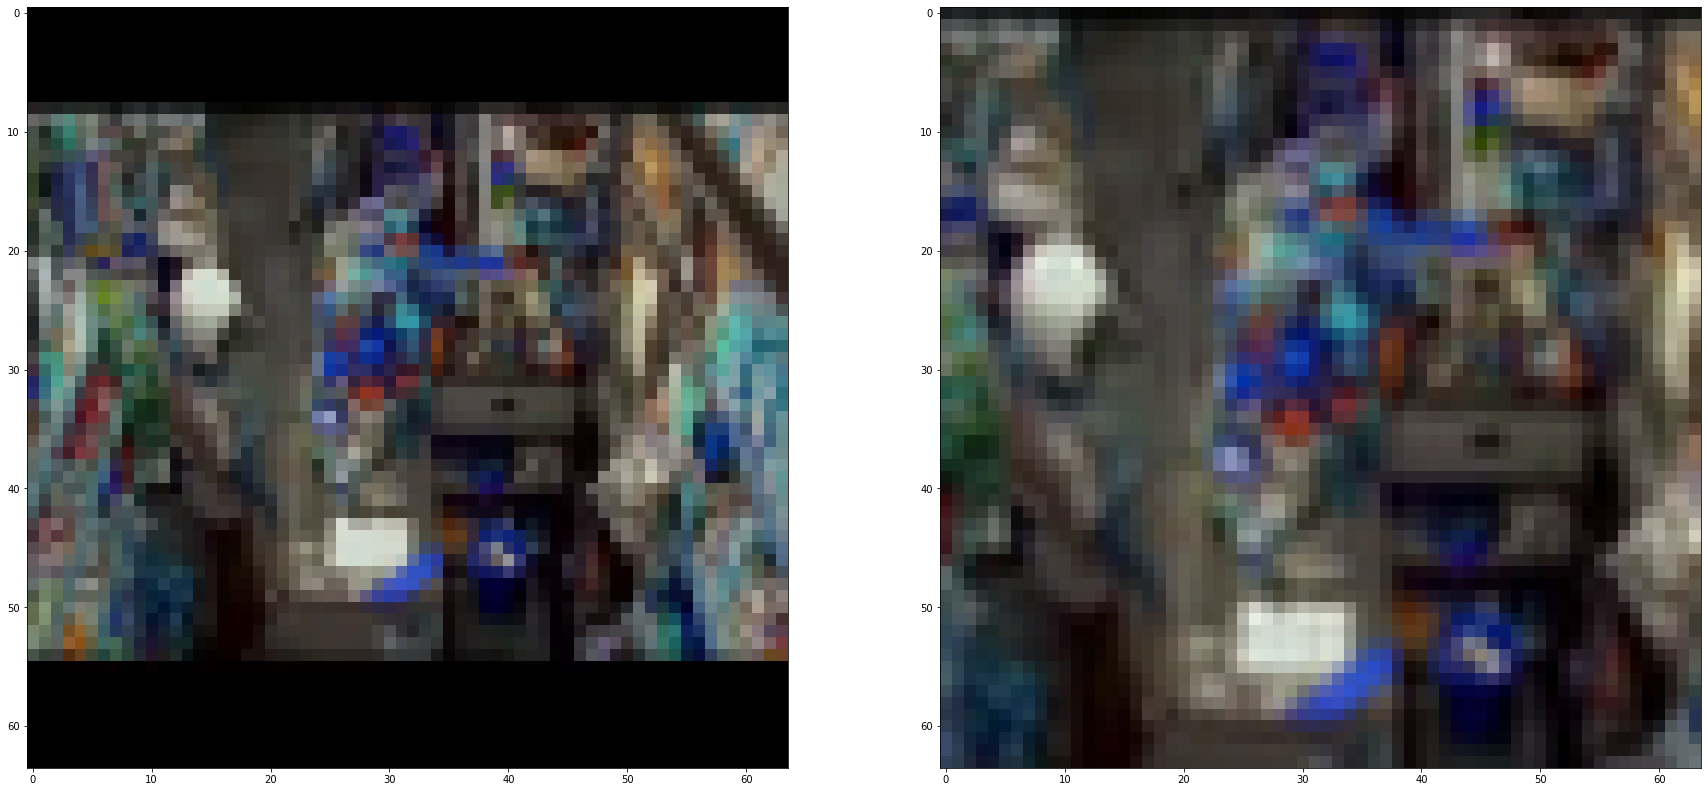

In [25]:
# contoh recrop gambar
testimg = cv2.imread("/content/CDD Selection/Train/Robbery/Robbery001_x264_210.png")
aaa = recrop_transform(recrop_transform(recrop_transform(recrop_transform(testimg))))
fig,ax = plt.subplots(1,2,figsize=(30,60))
ax[0].imshow(testimg)
ax[1].imshow(aaa)
plt.show()

In [26]:
!rm -rf "CDD Selection Clean Video"

In [27]:
FRAME_START_OFFSET = 48
FRAME_END_OFFSET = 48

# cleaning gambar dan digabung menjadi video-video agar lebih mudah 
for path in os.listdir(ORIGINAL_ROOT):
  # setiap folder TRAIN / TEST
  ori_path = f"{ORIGINAL_ROOT}/{path}"
  target_path = f"{TARGET_ROOT}/{path}"
  
  for categories in os.listdir(ori_path):
    # setiap categori
    cat_ori_path = f"{ori_path}/{categories}"
    cat_target_path = f"{target_path}/{'Normal' if categories.find('Normal') != -1 else 'Crime'}"
    os.makedirs(cat_target_path,exist_ok = True)
    path_dict = generate_sorted_filepaths(cat_ori_path)
    
    tqdmlist = tqdm(path_dict.keys(), desc=f"Processing: {cat_target_path}")
    
    for videoname in tqdmlist:
      # setiap video name

      # dicut agar langsung pada action

      # jika panjang video mencukupi di cut, sisanya dibiarkan
      if len(path_dict[videoname]) > (FRAME_START_OFFSET+FRAME_END_OFFSET)*2:
        imgpath_list = path_dict[videoname][FRAME_START_OFFSET:-FRAME_END_OFFSET]
      else:
        imgpath_list = path_dict[videoname]
      
      if len(imgpath_list) > 0:
        video_writer = cv2.VideoWriter(cat_target_path+f"/{videoname}.mp4",CODEC,12,(64,64))
      
      for imgpath in imgpath_list:
        # setiap gambar
        tqdmlist.set_description(f"Processing: {cat_target_path} Filename: {imgpath}")
        loaded_img = cv2.imread(imgpath)
        
        if check_good_images(BLACK_LIMIT,loaded_img):
          # cek jika gambar tidak hitam semua, jika tidak write menjadi video
          video_writer.write(recrop_transform(loaded_img))

      # save video
      if len(imgpath_list) > 0:
        video_writer.release()

Processing: CDD Selection Clean Video/Test/Normal:   0%|          | 0/150 [00:00<?, ?it/s]

Processing: CDD Selection Clean Video/Test/Crime:   0%|          | 0/5 [00:00<?, ?it/s]

Processing: CDD Selection Clean Video/Test/Crime:   0%|          | 0/13 [00:00<?, ?it/s]

Processing: CDD Selection Clean Video/Test/Crime:   0%|          | 0/21 [00:00<?, ?it/s]

Processing: CDD Selection Clean Video/Test/Crime:   0%|          | 0/5 [00:00<?, ?it/s]

Processing: CDD Selection Clean Video/Train/Normal:   0%|          | 0/800 [00:00<?, ?it/s]

Processing: CDD Selection Clean Video/Train/Crime:   0%|          | 0/95 [00:00<?, ?it/s]

Processing: CDD Selection Clean Video/Train/Crime:   0%|          | 0/87 [00:00<?, ?it/s]

Processing: CDD Selection Clean Video/Train/Crime:   0%|          | 0/29 [00:00<?, ?it/s]

Processing: CDD Selection Clean Video/Train/Crime:   0%|          | 0/145 [00:00<?, ?it/s]

In [28]:
# dizip
!zip -r cddfiltered.zip "/content/CDD Selection Clean Video"

updating: content/CDD Selection Clean Video/ (stored 0%)
updating: content/CDD Selection Clean Video/Test/ (stored 0%)
updating: content/CDD Selection Clean Video/Test/Crime/ (stored 0%)
updating: content/CDD Selection Clean Video/Test/Crime/Stealing079_x264.mp4 (deflated 3%)
updating: content/CDD Selection Clean Video/Test/Crime/Shoplifting049_x264.mp4 (deflated 3%)
updating: content/CDD Selection Clean Video/Test/Crime/Shoplifting022_x264.mp4 (deflated 3%)
updating: content/CDD Selection Clean Video/Test/Crime/Shoplifting016_x264.mp4 (deflated 3%)
updating: content/CDD Selection Clean Video/Test/Crime/Stealing062_x264.mp4 (deflated 5%)
updating: content/CDD Selection Clean Video/Test/Crime/Shoplifting044_x264.mp4 (deflated 4%)
updating: content/CDD Selection Clean Video/Test/Crime/Burglary021_x264.mp4 (deflated 5%)
updating: content/CDD Selection Clean Video/Test/Crime/Burglary035_x264.mp4 (deflated 21%)
updating: content/CDD Selection Clean Video/Test/Crime/Shoplifting007_x264.mp4 (

In [29]:
# dicopy ke google drive
shutil.copy("cddfiltered.zip","/content/drive/MyDrive/DeepLearningProject_CrimeDetection/cddfiltered.zip")

'/content/drive/MyDrive/DeepLearningProject_CrimeDetection/cddfiltered.zip'